In [2]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
import config

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "3_clean")
interm= os.join(root, "data", "2_intermediate")

plots= os.join(root, "code", "plots")

In [3]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [4]:
# files in clean data google drive
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r


In [5]:
# load codebook        
codebk = drive.CreateFile({'id': '1Lf7kV9_R-caFZV6_l8hMxAVjFSVFhvYl'})
codebk.GetContentFile('codebook.xlsx')  

codebk= pd.read_excel('codebook.xlsx', sheet_name = "predictors")
codebk.head()

C:\Users\Jennah\anaconda3\envs\geo_env\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Variable,Description,Source,Notes,Include_BBL,Include_Box
0,geofips,census tract geo identifier,Census ACS,NaN,0.0,0.0
1,geofips_recode,"census tract geo identifier, changes county to...",Census ACS,NaN,0.0,0.0
2,totpop,total population,Census ACS,NaN,1.0,1.0
3,popdens,total population per square mile,Census ACS,NaN,1.0,1.0
4,areasqmile,area,Census ACS,NaN,1.0,1.0


In [6]:
predictors_full = codebk.loc[codebk["Include_BBL"] == 1, "Variable"].apply(lambda x: x.strip())
predictors_full

2             totpop
3            popdens
4         areasqmile
5              males
6            females
           ...      
102        assesstot
103        exempttot
104        yearbuilt
105      landuse_cat
106    bldgclass_cat
Name: Variable, Length: 90, dtype: object

## Load building level analysis file

In [7]:
df_bbl = drive.CreateFile({'id': '1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G'})
df_bbl.GetContentFile('analysis_bbl.csv')  

df_bbl= pd.read_csv('analysis_bbl.csv').drop(["Unnamed: 0"], axis = 1)
df_bbl.head()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,bldgclass_A0,bldgclass_A6,bldgclass_A8,bldgclass_CM,bbl,boroct2010,vacate_ind,borough,landuse,bldgclass
0,2013.0,5555.0,1.0,4.0,6.0,6.0,345150.0,1317150.0,0.0,1899.0,...,0.0,0.0,0.0,0.0,1012090027,1018100,0.0,MN,2.0,C2
1,2517.0,6895.0,1.0,4.0,10.0,10.0,427500.0,1244700.0,0.0,1891.0,...,0.0,0.0,0.0,0.0,1012090028,1018100,0.0,MN,2.0,C5
2,10570.0,127289.0,1.0,17.0,69.0,69.0,2616300.0,12195900.0,136178.0,1930.0,...,0.0,0.0,0.0,0.0,1012090037,1018100,0.0,MN,3.0,D4
3,3926.0,20358.0,1.0,6.0,25.0,25.0,490500.0,1929600.0,92325.0,1961.0,...,0.0,0.0,0.0,0.0,1012090049,1018100,0.0,MN,3.0,D4
4,5035.0,21258.0,1.0,6.0,12.0,12.0,585000.0,1414350.0,15640.0,1905.0,...,0.0,0.0,0.0,0.0,1012090051,1018100,0.0,MN,3.0,D4


In [8]:
assert df_bbl["bbl"].isna().sum() == 0
assert df_bbl["holc_D"].isna().sum() == 0

In [9]:
assert df_bbl.loc[:, "vacate_ind"].isna().sum() == 0

In [10]:
print(df_bbl.columns)
df_bbl.describe()

Index(['lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'assessland', 'assesstot', 'exempttot', 'yearbuilt',
       ...
       'bldgclass_A0', 'bldgclass_A6', 'bldgclass_A8', 'bldgclass_CM', 'bbl',
       'boroct2010', 'vacate_ind', 'borough', 'landuse', 'bldgclass'],
      dtype='object', length=160)


,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,bldgclass_Z0,bldgclass_A2,bldgclass_A0,bldgclass_A6,bldgclass_A8,bldgclass_CM,bbl,boroct2010,vacate_ind,landuse
count,7.650260e+05,7.650260e+05,765026.000000,765026.000000,765026.000000,765026.000000,7.650260e+05,7.650260e+05,7.650260e+05,765026.000000,...,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,7.650260e+05,7.650260e+05,765026.000000,765026.000000
mean,3.812014e+03,5.051030e+03,1.324975,2.443933,4.689669,4.894059,5.407344e+04,2.821186e+05,5.387875e+04,1938.547234,...,0.000508,0.058912,0.011311,0.001029,0.000038,0.000001,3.548735e+09,3.541768e+06,0.003404,1.421477
std,2.318736e+04,3.520154e+04,2.726640,1.676083,42.058995,47.000007,5.127009e+05,2.549800e+06,1.355497e+06,68.722810,...,0.022544,0.235460,0.105749,0.032057,0.006157,0.001143,1.003515e+09,9.994487e+05,0.058243,0.842764
min,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000070e+09,1.000201e+06,0.000000,1.000000
25%,2.000000e+03,1.440000e+03,1.000000,2.000000,1.000000,1.000000,1.020000e+04,3.786000e+04,0.000000e+00,1920.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.036730e+09,3.030100e+06,0.000000,1.000000
50%,2.500000e+03,2.020000e+03,1.000000,2.000000,2.000000,2.000000,1.368000e+04,5.172000e+04,0.000000e+00,1931.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.012680e+09,4.010200e+06,0.000000,1.000000
75%,4.000000e+03,2.923000e+03,2.000000,2.750000,2.000000,2.000000,1.986000e+04,8.304000e+04,1.440000e+03,1960.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.107290e+09,4.092200e+06,0.000000,2.000000
max,1.225343e+07,1.354011e+07,1807.000000,98.000000,19201.000000,19203.000000,1.345064e+08,6.899244e+08,4.435560e+08,2021.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.080500e+09,5.032300e+06,1.000000,4.000000


In [11]:
df_bbl= pd.get_dummies(df_bbl, columns=["borough"])
borocols= ["borough_" + x for x in ["BK", "BX", "MN", "QN", "SI"]]

In [12]:
df_bbl.loc[:, predictors_full].head()

,totpop,popdens,areasqmile,males,females,pop18under,pop18_34,pop35_64,pop65plus,pophispanic,...,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,landuse_cat,bldgclass_cat
0,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,4.0,6.0,6.0,345150.0,1317150.0,0.0,1899.0,2.0,0
1,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,4.0,10.0,10.0,427500.0,1244700.0,0.0,1891.0,2.0,1
2,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,17.0,69.0,69.0,2616300.0,12195900.0,136178.0,1930.0,3.0,2
3,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,6.0,25.0,25.0,490500.0,1929600.0,92325.0,1961.0,3.0,2
4,8496.0,158948.7,0.053451,4072.0,4424.0,1037.0,2010.0,3202.0,2247.0,1400.0,...,1.0,6.0,12.0,12.0,585000.0,1414350.0,15640.0,1905.0,3.0,2


In [13]:
outcomes= ["vacate_ind"]
df_bbl[outcomes].head()

# very small percentage of the data has had a fire
df_bbl[outcomes[0]].mean()

0.003403805883721599

### Running LASSO to determine important variables

In [14]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df_bbl.loc[:, predictors_full])
X_scaled = scaler.transform(df_bbl.loc[:, predictors_full])

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_scaled, df_bbl.loc[:, outcomes], 
                                                            test_size=0.3, random_state=999)

In [15]:
coef_comp= pd.DataFrame(predictors_full).rename({'Variable': 'Features'}, axis = 1)
coef_comp

,Features
2,totpop
3,popdens
4,areasqmile
5,males
6,females
...,...
102,assesstot
103,exempttot
104,yearbuilt
105,landuse_cat


In [16]:
from sklearn import linear_model

param_grid= {'alpha':[0.00001, 0.0001, 0.0005, 0.0008, 0.0001]}
clf= linear_model.Lasso(fit_intercept = True)
gr = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1)
rs = gr.fit(X_train_l, y_train_l)

print(rs.best_params_)
print(rs.best_score_)

{'alpha': 0.0005}
0.08153795512895834


In [17]:
clf= linear_model.Lasso(fit_intercept = True, alpha = 0.0005) #rs.best_params_['alpha'])
clf.fit(X_train_l, y_train_l)
coef_comp['coef_alpha_0.0005']= clf.coef_

In [18]:
clf= linear_model.Lasso(fit_intercept = True, alpha = 0.001)
clf.fit(X_train_l, y_train_l)
coef_comp['coef_alpha_0.001']= clf.coef_

In [19]:
# feature selection from LASSOs
# fewer features chosen
lasso_coef= coef_comp.loc[coef_comp['coef_alpha_0.0005'] != 0].sort_values('coef_alpha_0.0005', ascending = False)
print(lasso_coef.shape)
print(lasso_coef.loc[lasso_coef["coef_alpha_0.001"] != 0].shape)
lasso_coef

(11, 3)
(9, 3)


,Features,coef_alpha_0.0005,coef_alpha_0.001
86,hpd_b_c_vio,0.011581,0.008886
85,hpd_fire_vio,0.002446,0.002137
105,landuse_cat,0.000865,0.000503
3,popdens,0.000551,0.000451
99,unitsres,0.000547,0.000379
55,pcthoilker,0.000412,0.000132
96,bldgarea,0.000361,0.000134
11,pophispanic,0.000057,0.000000
34,medianhhincome,-0.000416,-0.000000
89,hpd_b_c_vio_per_unit,-0.001037,-0.000030


In [20]:
lasso_coef.to_csv(os.join(interm, "lasso_vars.csv"))

# (1) Decision Trees and Random Forest Models

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

X = df_bbl.loc[:, predictors_full].fillna(0)
y = df_bbl.loc[:, "vacate_ind"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

dt = DecisionTreeClassifier(max_depth=10, random_state = 99)
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)

# accuracy is very high, but that is bc most are 0s!
accuracy= (y_predict == y_test).value_counts(normalize=True)[True]
accuracy

0.996270282517385

__Area under the curve__

In [22]:
dt=DecisionTreeClassifier(random_state = 99)
dt.fit(X_train,y_train)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
roc_auc_score(np.array(y_test),pred)

0.5702453545294232

In [23]:
# vs. random chance (only slightly better)
pred=np.random.random(len(X_test))
roc_auc_score(np.array(y_test.apply(int)),pred)

0.5192330826762421

## Tuning

In [24]:
# tune using the param grid
# optimize over the f1 score which is the tradeoff between precision and recall
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier(random_state = 99)
gr=GridSearchCV(dt,param_grid=param_grid, scoring='f1')
rs=gr.fit(X_train,y_train)
pred= rs.predict(X_test)
print(rs.best_params_)

## look at precision and recall rates
precision_recall_fscore_support(y_test, pred)

{'max_depth': 19}


(array([0.99688229, 0.1417004 ]),
 array([0.99814624, 0.08928571]),
 array([0.99751386, 0.10954617]),
 array([228724,    784], dtype=int64))

In [25]:
# tune using the param grid
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier(random_state = 99)
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train,y_train)
pred= rs.predict(X_test)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 5}
ROC AUC: 0.9727776630973826
Precision: 0.6666666666666666
Recall: 0.02806122448979592


In [26]:
# also depict the ROC AUC
pred_prob= rs.predict_proba(X_test)[:,1]

print(roc_auc_score(np.array(y_test),pred_prob))

0.9727776630973826


In [27]:
dt=DecisionTreeClassifier(max_depth = rs.best_params_['max_depth'], random_state= 99)
dt.fit(X_train,y_train)
pred_prob= dt.predict_proba(X_test)[:,1]

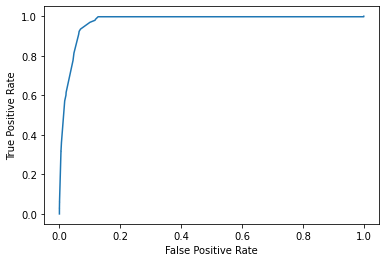

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, pred_prob, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

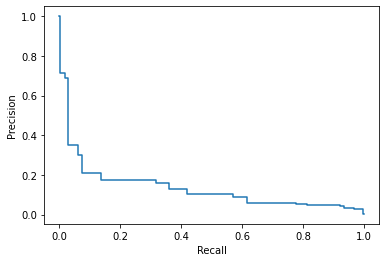

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, pred_prob, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

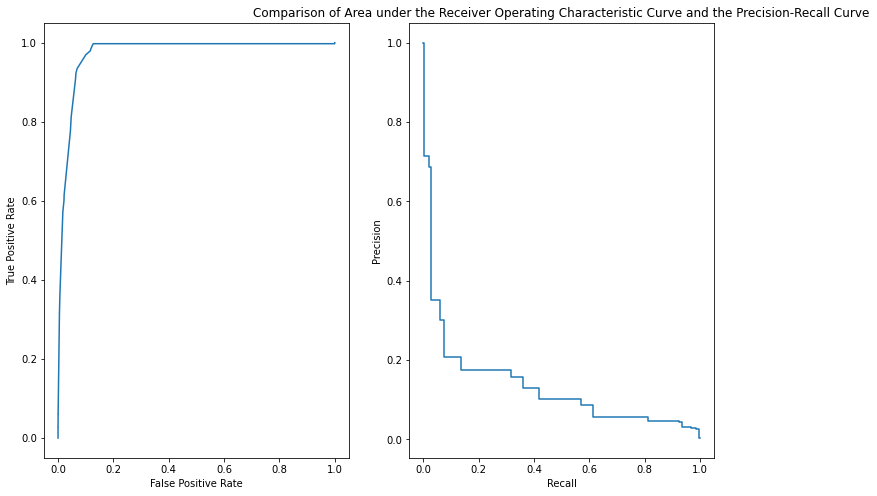

In [30]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.title("Comparison of Area under the Receiver Operating Characteristic Curve and the Precision-Recall Curve")
plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall.png'))

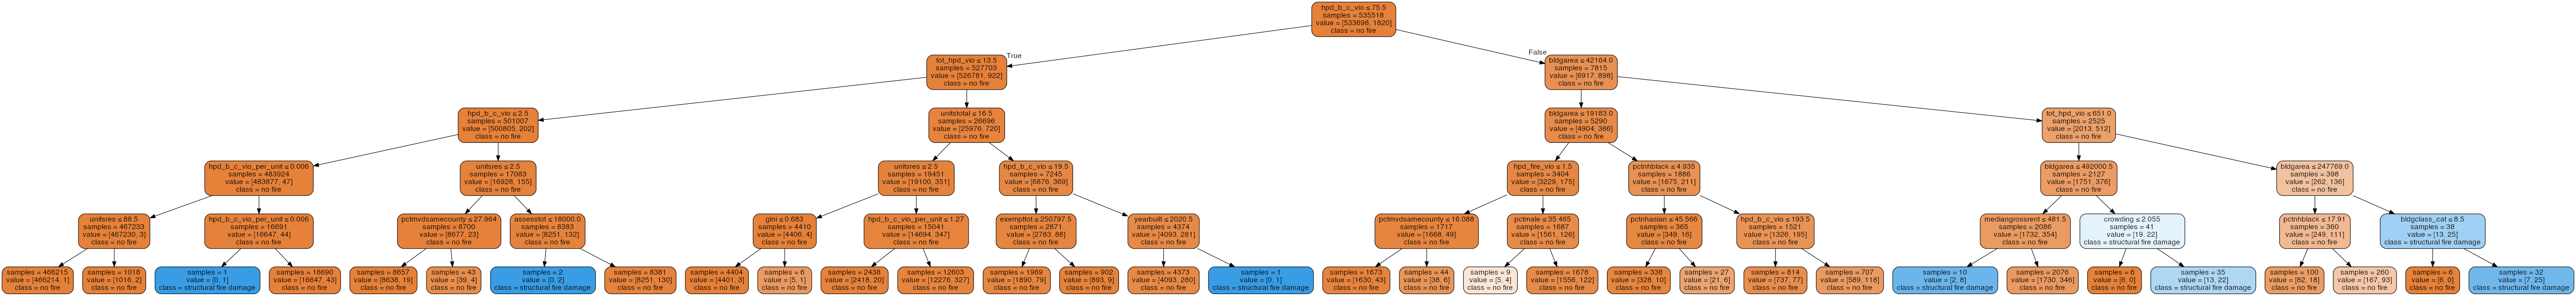

In [31]:
from sklearn import tree
from IPython.display import Image  
import pydotplus

# visualize the tree
dt = DecisionTreeClassifier(max_depth= 5, random_state = 99)
dt.fit(X_train, y_train)

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no fire','structural fire damage'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_dt_bbl.png'))
Image(graph.create_png())

## Feature Importance

In [32]:
dt = DecisionTreeClassifier(max_depth= 5, random_state = 99) #rs.best_params_['max_depth'])
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
ft= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft.to_csv(os.join(interm, 'feature_importance_bbl.csv'))
ft

,variables,importance
69,hpd_b_c_vio,0.50554
79,bldgarea,0.208531
67,tot_hpd_vio,0.131449
83,unitstotal,0.027785
40,pctnhblack,0.021296
31,mediangrossrent,0.019428
89,bldgclass_cat,0.015009
82,unitsres,0.011738
48,crowding,0.009849
85,assesstot,0.009432


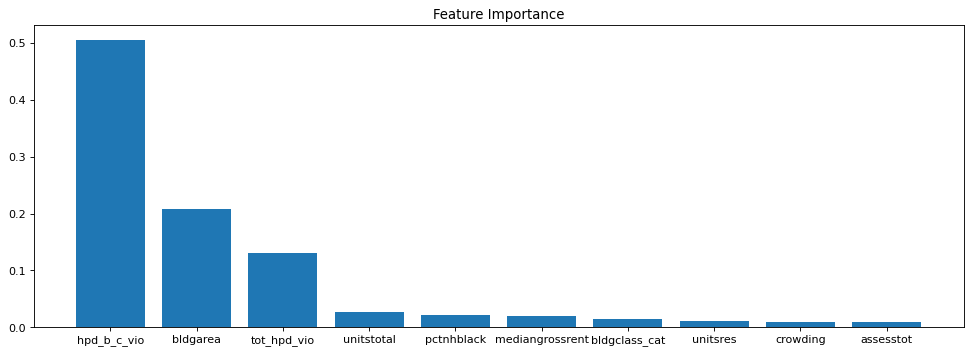

In [33]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,0],
        Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,1])
plt.title("Feature Importance");
plt.savefig(os.join(plots, 'feature_importance_bbl.png'))

## Random Forests

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_depth = 5, random_state = 99)
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))

print("Precision and recall")
precision_recall_fscore_support(y_test, (pred > 0.5))

0.9766877177564334
Precision and recall


C:\Users\Jennah\anaconda3\envs\geo_env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.996584, 0.      ]),
 array([1., 0.]),
 array([0.99828908, 0.        ]),
 array([228724,    784], dtype=int64))

In [35]:
param_grid = {'max_depth':range(1,20)}
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 30, random_state = 99)
gs = GridSearchCV(rf, param_grid=param_grid, scoring='roc_auc')
rs = gs.fit(X_train,y_train)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 8}
ROC AUC: 0.9774548089596622
Precision: 0.6
Recall: 0.007653061224489796


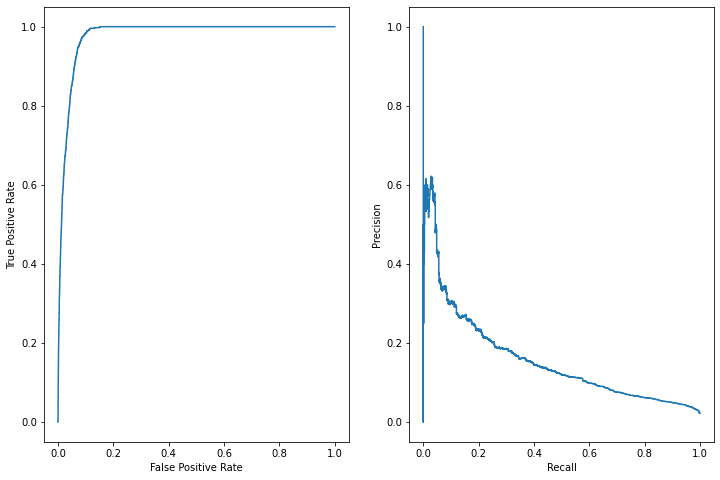

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)

plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall2.png'))

### CMM and other ensembles

In [37]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=30, random_state = 99, max_depth = rs.best_params_['max_depth'])
rf.fit(X_train,y_train)

# randomly generate a sample of xs
X_rand= pd.DataFrame({x:X_train[x].sample(n = round(0.25*X_train.shape[0])).reset_index(drop = True) for x in X_train.columns})
y_rand= rf.predict(X_rand)

In [38]:
# create the cmm training datasets
X_train_cmm= pd.concat([X_rand, X_train], axis = 0, ignore_index = True)
y_train_cmm= pd.concat([pd.DataFrame(y_rand), y_train], axis = 0, ignore_index = True)

In [39]:
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier(random_state = 99)
gr=GridSearchCV(dt,param_grid=param_grid, scoring='f1')
rs=gr.fit(X_train_cmm,y_train_cmm)
print(rs.best_params_)

{'max_depth': 19}


In [40]:
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

ROC AUC: 0.7624274496550338
Precision: 0.14744801512287334
Recall: 0.09948979591836735


In [41]:
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier(random_state = 99)
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train_cmm,y_train_cmm)

print(rs.best_params_)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rs.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

{'max_depth': 4}
ROC AUC: 0.9756468249407806
Precision: 0.0
Recall: 0.0


C:\Users\Jennah\anaconda3\envs\geo_env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
dt = DecisionTreeClassifier(max_depth= 4, random_state = 99) # choose value for visualizing
dt.fit(X_train_cmm, y_train_cmm)

Feature_importance=pd.DataFrame([list(X_train_cmm.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
ft2= Feature_importance.sort_values(by="importance",ascending=False)
#ft2.to_csv(os.join(interm, 'feature_importance_bbl2.csv'))
ft2.loc[ft2['importance']>0]

,variables,importance
69,hpd_b_c_vio,0.513882
79,bldgarea,0.230621
67,tot_hpd_vio,0.071401
83,unitstotal,0.058261
82,unitsres,0.055116
68,hpd_fire_vio,0.035055
40,pctnhblack,0.02744
53,pcthoilker,0.008224


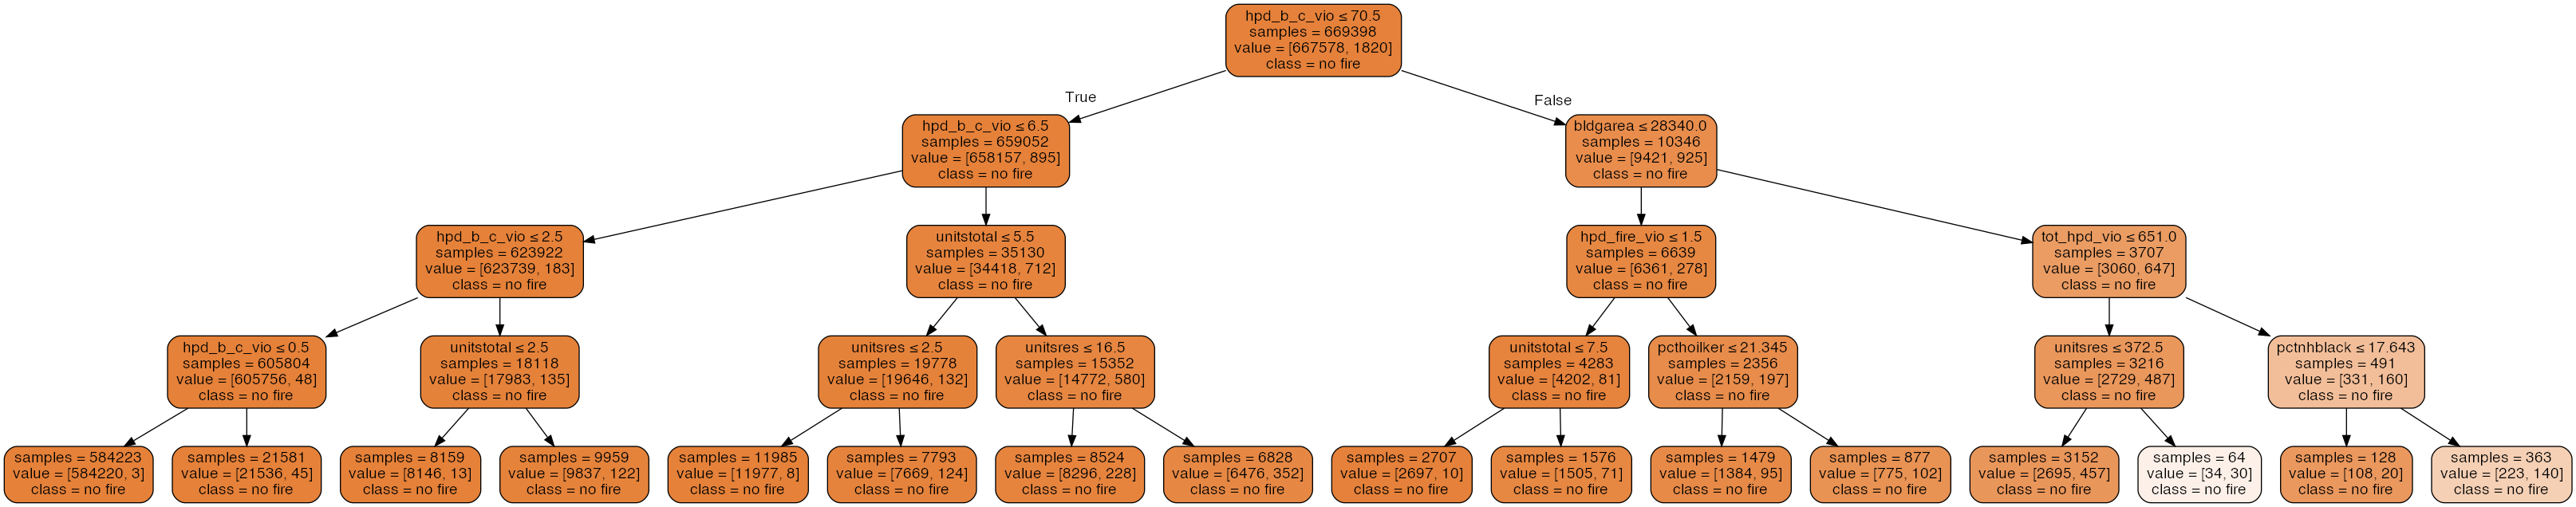

In [43]:
thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no fire','structural fire event'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_bbl_cmm.png'))
Image(graph.create_png())

## (2) Bayes Nets

In [44]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt

In [45]:
impt_vars= ['vacate_ind'] + ft.loc[ft['importance']>0, "variables"].tolist()
# use landuse instead since bldgclass has many values
impt_vars= [x if x != 'bldgclass_cat' else 'landuse_cat'  for x in impt_vars]
impt_vars

['vacate_ind',
 'hpd_b_c_vio',
 'bldgarea',
 'tot_hpd_vio',
 'unitstotal',
 'pctnhblack',
 'mediangrossrent',
 'landuse_cat',
 'unitsres',
 'crowding',
 'assesstot']

vacate_ind
hpd_b_c_vio


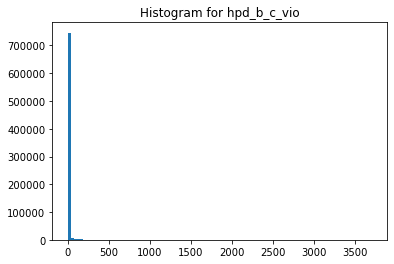

None
bldgarea


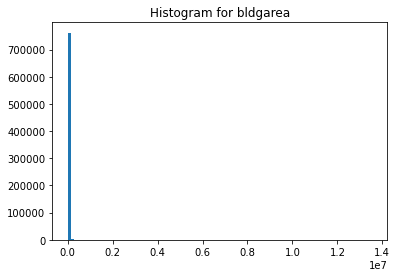

None
tot_hpd_vio


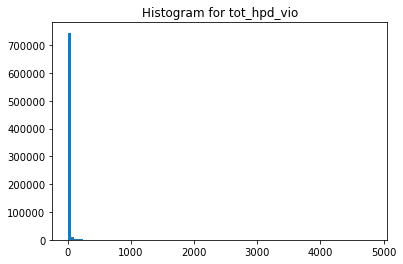

None
unitstotal


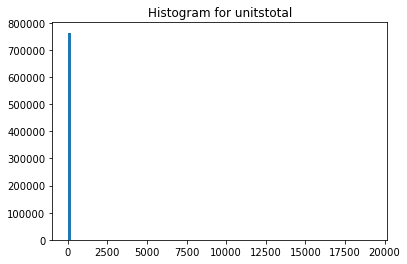

None
pctnhblack


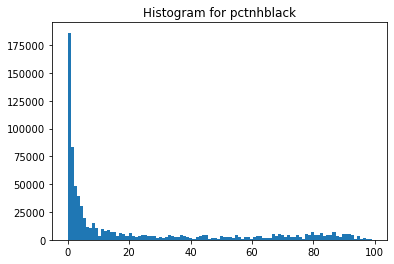

None
mediangrossrent


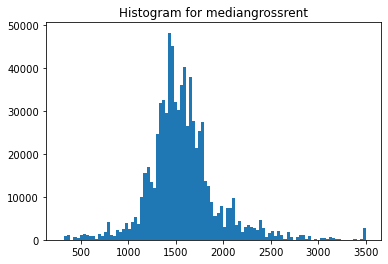

None
landuse_cat
unitsres


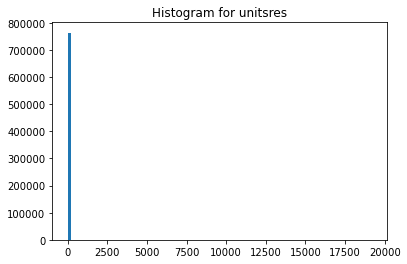

None
crowding


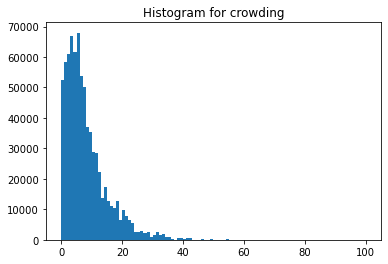

None
assesstot


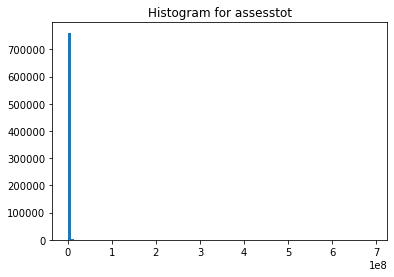

None


In [46]:
df_bbl_disc= df_bbl.loc[:, impt_vars].copy()
# need to discretize the data, also look at distributions
for i in impt_vars:
    print(i)
    if len(df_bbl_disc.loc[:, i].unique()) > 5:
        plt.hist(df_bbl_disc.loc[:, i], bins = 100);
        plt.title("Histogram for {}".format(i))
        print(plt.show())
        df_bbl_disc.loc[:, i] = pd.qcut(df_bbl_disc.loc[:, i], q=4, labels=False, duplicates = 'drop')

In [47]:
# create test train split for testing DAG
train, test = train_test_split(df_bbl_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [48]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('bldgarea', 'assesstot'), ('bldgarea', 'pctnhblack'), ('bldgarea', 'crowding'), ('bldgarea', 'landuse_cat'), ('bldgarea', 'mediangrossrent'), ('unitstotal', 'unitsres'), ('unitstotal', 'landuse_cat'), ('unitstotal', 'bldgarea'), ('unitstotal', 'crowding'), ('unitstotal', 'pctnhblack'), ('pctnhblack', 'assesstot'), ('pctnhblack', 'crowding'), ('mediangrossrent', 'crowding'), ('mediangrossrent', 'assesstot'), ('mediangrossrent', 'pctnhblack'), ('mediangrossrent', 'vacate_ind'), ('landuse_cat', 'vacate_ind'), ('unitsres', 'landuse_cat'), ('unitsres', 'assesstot'), ('unitsres', 'mediangrossrent'), ('unitsres', 'bldgarea'), ('unitsres', 'vacate_ind'), ('assesstot', 'crowding'), ('assesstot', 'landuse_cat')]


In [49]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['vacate_ind', 'hpd_b_c_vio', 'bldgarea', 'tot_hpd_vio', 'unitstotal', 'pctnhblack', 'mediangrossrent', 'landuse_cat', 'unitsres', 'crowding', 'assesstot']


In [50]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of bldgarea:
+-------------+----------------------+-----+---------------+---------------+----------------------+
| unitsres    | unitsres(0)          | ... | unitsres(2)   | unitsres(2)   | unitsres(2)          |
+-------------+----------------------+-----+---------------+---------------+----------------------+
| unitstotal  | unitstotal(0)        | ... | unitstotal(0) | unitstotal(1) | unitstotal(2)        |
+-------------+----------------------+-----+---------------+---------------+----------------------+
| bldgarea(0) | 0.5197432645587381   | ... | 0.25          | 0.25          | 0.004937779962191407 |
+-------------+----------------------+-----+---------------+---------------+----------------------+
| bldgarea(1) | 0.30757176725754654  | ... | 0.25          | 0.25          | 0.03575915161022268  |
+-------------+----------------------+-----+---------------+---------------+----------------------+
| bldgarea(2) | 0.1206841344505492   | ... | 0.25          | 0.25          | 0.2055

In [69]:
# get the conditional distributions
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

d= {}
for i in range(4):
    for j in range(4):
        for k in range(1,5):
            # print conditional distributions
            if train.loc[(train["mediangrossrent"]==j) & (train["landuse_cat"]==k)&(train["unitsres"]==i)].shape[0] > 0:
                print("\nunitsres=",i)
                print("mediangrossrent=", j)
                print("landuse_cat=", k)
                cpd_comp= infer.query(['vacate_ind'], evidence={'unitsres': i, 'mediangrossrent': j, 'landuse_cat': k})
                d["unitsres="+str(i)+"; mediangrossrent="+str(j)+"; landuse_cat="+str(k)]= cpd_comp.values[1]
                print(cpd_comp)
                


unitsres= 0
mediangrossrent= 0
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            1.0000 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0000 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 0
landuse_cat= 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9675 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0325 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 0
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9999 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0001 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 1
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            1.0000 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0000 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 1
landuse_cat= 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9138 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0862 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 1
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9994 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0006 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 2
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            1.0000 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0000 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 2
landuse_cat= 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9528 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0472 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 2
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9999 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0001 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 3
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            1.0000 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0000 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 3
landuse_cat= 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.8655 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.1345 |
+-----------------+-------------------+

unitsres= 0
mediangrossrent= 3
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9999 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0001 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 0
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9997 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0003 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 0
landuse_cat= 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9980 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0020 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 0
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9986 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0014 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 1
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            1.0000 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0000 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 1
landuse_cat= 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9976 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0024 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 1
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9991 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0009 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 2
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9999 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0001 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 2
landuse_cat= 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9973 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0027 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 2
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9987 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0013 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 3
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            1.0000 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0000 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 3
landuse_cat= 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9991 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0009 |
+-----------------+-------------------+

unitsres= 1
mediangrossrent= 3
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9989 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0011 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 0
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9832 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0168 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 0
landuse_cat= 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9829 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0171 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 0
landuse_cat= 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9096 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0904 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 0
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9571 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0429 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 1
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9887 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0113 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 1
landuse_cat= 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9928 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0072 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 1
landuse_cat= 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9248 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0752 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 1
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9716 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0284 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 2
landuse_cat= 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9939 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0061 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 2
landuse_cat= 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9424 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0576 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 2
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9819 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0181 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 3
landuse_cat= 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9800 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0200 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 3
landuse_cat= 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9957 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0043 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 3
landuse_cat= 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9858 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0142 |
+-----------------+-------------------+

unitsres= 2
mediangrossrent= 3
landuse_cat= 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------------+-------------------+
| vacate_ind      |   phi(vacate_ind) |
+=================+===================+
| vacate_ind(0.0) |            0.9854 |
+-----------------+-------------------+
| vacate_ind(1.0) |            0.0146 |
+-----------------+-------------------+


In [79]:
pd.DataFrame.from_dict(d, orient = "index", columns = ["conditional_prob"]).sort_values("conditional_prob", ascending = False)

,conditional_prob
unitsres=0; mediangrossrent=3; landuse_cat=3,0.134518
unitsres=2; mediangrossrent=0; landuse_cat=3,0.090411
unitsres=0; mediangrossrent=1; landuse_cat=3,0.086207
unitsres=2; mediangrossrent=1; landuse_cat=3,0.075187
unitsres=2; mediangrossrent=2; landuse_cat=3,0.057611
unitsres=0; mediangrossrent=2; landuse_cat=3,0.047170
unitsres=2; mediangrossrent=0; landuse_cat=4,0.042940
unitsres=0; mediangrossrent=0; landuse_cat=3,0.032468
unitsres=2; mediangrossrent=1; landuse_cat=4,0.028432
unitsres=2; mediangrossrent=3; landuse_cat=1,0.020000


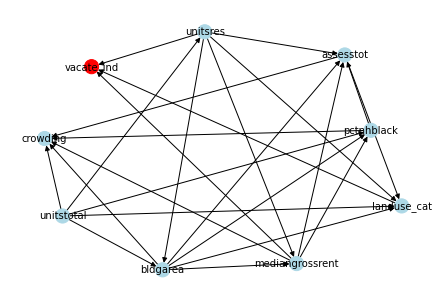

<Figure size 864x720 with 0 Axes>

In [80]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['vacate_ind'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('dag_bbl.png')

In [ ]:
pred = model.predict(test.loc[:, ['pctnhblack', 'bldgarea','mediangrossrent', 'crowding',
                                  'unitsres', 'unitstotal', 'assesstot', 'landuse_cat']],
                    stochastic = True)
print(pred)

In [ ]:
pred_proba = model.predict_probability(test.loc[:, ['pctnhblack', 'bldgarea','mediangrossrent', 'crowding',
                                  'unitsres', 'unitstotal', 'assesstot', 'landuse_cat']])
print(pred_proba)

In [ ]:
# calc out of sample accuracy
print("\nOS accuracy for vacate orders")
print((pred['vacate_ind'].reset_index(drop = True) == test['vacate_ind'].reset_index(drop = True)).mean())

print("\nOS precision and recall for vacate orders")
pre_rec= precision_recall_fscore_support(np.asarray(test['vacate_ind']), 
                                      np.asarray(pred['vacate_ind']))

print("Precision:", pre_rec[0][1])
print("Recall:", pre_rec[1][1])

In [ ]:
## calculate roc auc

# Anomaly Detection

## Isolation forests

In [ ]:
from sklearn.ensemble import IsolationForest

# generate outliers
X_outliers= X.loc[X.loc[y==1].index, :]
X_reg= X.loc[X.loc[y==0].index, :]
# generate test and train data
X_train, X_test= train_test_split(X_reg, test_size=0.3, random_state=999)

# fit the model
if_clf = IsolationForest(max_samples=100, random_state=99)
if_clf.fit(X_train)
y_pred_train = if_clf.predict(X_train)
y_pred_test = if_clf.predict(X_test)
y_pred_outliers = if_clf.predict(X_outliers)

In [ ]:
print("Percent training classified as inliers:", np.mean(y_pred_train==1))
print("Percent test data classified as inliers:", np.mean(y_pred_test==1))
print("Percent outliers classified as inliers:", np.mean(y_pred_outliers==1))

In [ ]:
# OS accuracy
print("OS accuracy:", np.mean(np.append(y_pred_test, y_pred_outliers)== np.append(np.repeat(1, len(y_pred_test)), np.repeat(-1, len(y_pred_outliers)))))
# low precision and recall (esp. compared to random forest)
print("\nOS precision and recall for isolation tree")
pre_rec= precision_recall_fscore_support(np.append(y_pred_test, y_pred_outliers)==-1,
                                      np.append(np.repeat(1, len(y_pred_test)), np.repeat(-1, len(y_pred_outliers)))==-1)

print("Precision:", pre_rec[0][1])
print("Recall:", pre_rec[1][1])